In [26]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
from os import path
import pickle
import pandas as pd
pd.options.display.width = 500
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [13, 13]

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [ ]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green'}


In [163]:
df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_info_file:
    results_info = yaml.safe_load(results_info_file)

run_parameters = results_info['run_parameter_names']
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]

printmd("## Number of Runs")
printmd(f"    {len(df.run_id.unique())}")

printmd("## Run Parameters")
for name in run_parameters:
    values = list(df[name][df[name].notnull()].unique())
    printmd(f"    {name:<70}", sorted(values))

printmd("## Metrics")
for name in metrics_and_versions:
    if name in metrics_versions:
        if len(df[name].unique()) == 1:
            printmd(f"    {name:<70} {sorted(df[name].unique())}")
        else:
            printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
    else:
        printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g}]")


## Number of Runs

    189

## Run Parameters

    max_steering_angle_deg                                                 [20.0, 40.0, 90.0]

    run_index                                                              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    localization_node                                                      ['amcl']

    odometry_mode                                                          ['encoder', 'ground_truth']

    global_planner_node                                                    ['navfn', 'smac']

    environment_name                                                       ['7A-2', 'airlab', 'fr079', 'intel', 'mexico', 'office_b']

    robot_model                                                            ['hunter2', 'turtlebot3_waffle_performance_modelling']

    local_planner_node                                                     ['dwb', 'rpp', 'teb']

## Metrics

    controller_cpu_time                                                    min:       1.47             avg:      65.87             max:      462.8]

    planner_cpu_time                                                       min:       0.39             avg:       27.5             max:      158.7]

    system_cpu_time                                                        min:       3.41             avg:      106.1             max:      673.9]

    controller_max_memory                                                  min:    2.4e+07             avg:  4.588e+07             max:  8.086e+07]

    planner_max_memory                                                     min:  2.631e+07             avg:  5.414e+08             max:  3.056e+10]

    system_max_memory                                                      min:  1.462e+08             avg:  7.159e+08             max:  3.075e+10]

    cpu_time_and_max_memory_version                                        [1]

    trajectory_length_version                                              [1]

    trajectory_length                                                      min:          0             avg:      20.34             max:      103.4]

    execution_time_version                                                 [1]

    execution_time                                                         min:      0.297             avg:      88.29             max:      459.2]

    success_rate_version                                                   [1]

    success_rate                                                           min:          0             avg:     0.7037             max:          1]

    odometry_error_alpha_1_mean                                            min:          0             avg:  2.318e-06             max:  0.0001665]

    odometry_error_alpha_1_std                                             min:          0             avg:  2.252e-05             max:    0.00165]

    odometry_error_alpha_2_mean                                            min:          0             avg:  3.707e-06             max:   0.000603]

    odometry_error_alpha_2_std                                             min:          0             avg:  2.506e-05             max:   0.003801]

    odometry_error_alpha_3_mean                                            min:  2.315e-17             avg:  7.419e-07             max:  0.0001165]

    odometry_error_alpha_3_std                                             min:  1.864e-17             avg:  5.423e-06             max:  0.0007724]

    odometry_error_alpha_4_mean                                            min:  2.311e-17             avg:  7.055e-07             max:  3.839e-05]

    odometry_error_alpha_4_std                                             min:  1.717e-17             avg:  7.854e-06             max:  0.0004642]

    odometry_error_version                                                 [1]

    localization_update_absolute_translation_error_mean                    min:  0.0009618             avg:      0.863             max:       51.9]

    localization_update_absolute_translation_error_std                     min:  0.0004627             avg:     0.7164             max:      39.83]

    localization_update_absolute_rotation_error_mean                       min:   0.001959             avg:    0.08177             max:      1.668]

    localization_update_absolute_rotation_error_std                        min:  0.0009048             avg:    0.07657             max:       1.19]

    localization_update_relative_translation_error_mean                    min:  0.0006831             avg:   0.007801             max:      0.136]

    localization_update_relative_translation_error_std                     min:  0.0003619             avg:    0.01322             max:     0.5118]

    localization_update_relative_rotation_error_mean                       min:  0.0007059             avg:    0.01037             max:     0.2515]

    localization_update_relative_rotation_error_std                        min:  0.0004752             avg:     0.0302             max:     0.5354]

    localization_update_normalized_relative_translation_error_mean         min:   0.004089             avg:    0.04667             max:     0.9581]

    localization_update_normalized_relative_translation_error_std          min:    0.00153             avg:     0.1113             max:      5.165]

    localization_update_normalized_relative_rotation_error_mean            min:   0.003725             avg:     0.2233             max:      7.546]

    localization_update_normalized_relative_rotation_error_std             min:   0.002454             avg:      0.878             max:      33.86]

    localization_update_error_version                                      [1]

    localization_update_rate_mean                                          min:     0.4923             avg:      1.025             max:      4.157]

    localization_update_rate_std                                           min:    0.04391             avg:     0.4521             max:      7.011]

    localization_update_rate_version                                       [1]

In [164]:
print(len(df.run_id.unique()))

189


In [165]:
df.groupby([df.robot_model, df.local_planner_node, df.global_planner_node])[metrics].agg(['min', 'mean', 'max'])

controller_cpu_time                     planner_cpu_time                    system_cpu_time                     controller_max_memory  ... localization_update_normalized_relative_rotation_error_mean localization_update_normalized_relative_rotation_error_std                      localization_update_rate_mean                     localization_update_rate_std                    
                                                                                               min        mean     max              min       mean     max             min        mean     max                   min  ...                                                         max                                                        min      mean        max                           min      mean       max                          min      mean       max
robot_model                             local_planner_node global_planner_node                                                                                                                                        ...                                                                                                                                                                                                                                               
hunter2                                 teb                navfn                             42.47  158.187500  409.34             5.66  33.055000   96.16           52.73  206.093333  532.85              68909056  ...                                           0.091080                                                    0.005114          0.071620   0.196569                      1.079379  1.589562  4.157143                     0.204616  1.389916  7.011186
                                                           smac                               3.51   85.566667  209.54             0.72  31.465833   98.88            5.27  125.652500  294.26              68308992  ...                                           0.049614                                                    0.012589          0.057952   0.091005                      1.047118  1.566955  2.983500                     0.252213  1.257915  4.435241
turtlebot3_waffle_performance_modelling dwb                navfn                              1.47   36.318130  198.66             0.85  24.757642  137.53            3.41   74.069106  519.31              30745600  ...                                           7.546265                                                    0.002454          1.121034  33.860589                      0.492308  0.928377  1.136000                     0.043911  0.295072  0.956682
                                        rpp                navfn                              5.00   26.210000   49.23             4.51  24.765000   46.89           13.06   62.386667  115.26              24002560  ...                                           2.603327                                                    0.079629          1.744659   5.524493                      0.542105  0.636596  0.722891                     0.062434  0.612738  0.812985
                                        teb                navfn                             26.97  147.050000  396.55             1.49  32.320000  102.46           30.74  193.142778  529.92              69536768  ...                                           0.321872                                                    0.023840          0.228975   1.544847                      0.738462  1.066748  1.266263                     0.154560  0.325272  0.509902
                                                           smac                               3.90  125.207778  462.75             0.39  35.978333  158.70            5.34  173.020556  673.89              66836480  ...                                           0.485938                                                    0.023635          0.364986   4.067819                      0.707407  1.190916  3.334826                

controller_cpu_time                     planner_cpu_time                    system_cpu_time                    
                                                                                               min        mean     max              min       mean     max             min        mean     max
robot_model                             local_planner_node global_planner_node                                                                                                                
turtlebot3_waffle_performance_modelling rpp                navfn                              5.00   26.210000   49.23             4.51  24.765000   46.89           13.06   62.386667  115.26
                                        dwb                navfn                              1.47   36.318130  198.66             0.85  24.757642  137.53            3.41   74.069106  519.31
hunter2                                 teb                smac                               3.51   85.566667  209.54             0.72  31.465833   98.88            5.27  125.652500  294.26
turtlebot3_waffle_performance_modelling teb                smac                               3.90  125.207778  462.75             0.39  35.978333  158.70            5.34  173.020556  673.89
                                                           navfn                             26.97  147.050000  396.55             1.49  32.320000  102.46           30.74  193.142778  529.92
hunter2                                 teb                navfn                             42.47  158.187500  409.34             5.66  33.055000   96.16           52.73  206.093333  532.85

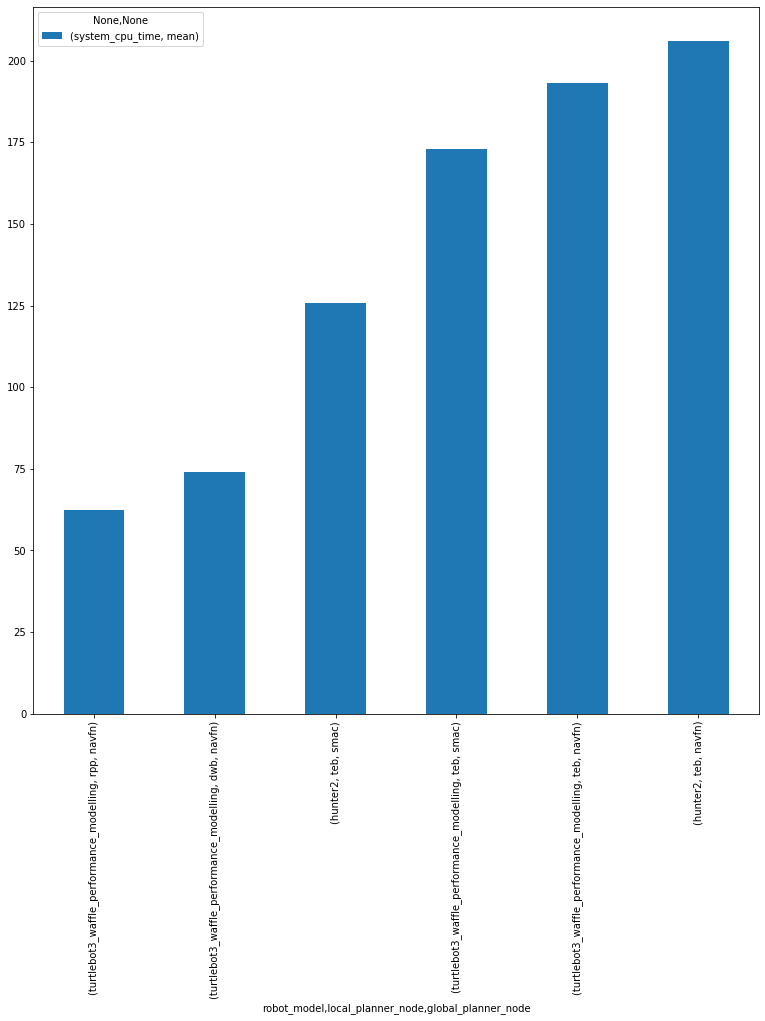

In [177]:
cpu_time_metrics_df = df.groupby([df.robot_model, df.local_planner_node, df.global_planner_node])[cpu_time_metrics].agg(['min', 'mean', 'max']).sort_values(by=('system_cpu_time', 'mean'))
cpu_time_metrics_df.plot.bar(y=('system_cpu_time', 'mean'))
cpu_time_metrics_df

controller_max_memory                       planner_max_memory                            system_max_memory                           
                                                                                                 min       mean        max                min         mean           max               min         mean           max
robot_model                             local_planner_node global_planner_node                                                                                                                                       
turtlebot3_waffle_performance_modelling rpp                navfn                           22.890625  26.238770  32.753906          25.380859    57.958822    130.758789        139.409180   208.888835    369.644531
                                        dwb                navfn                           29.321289  32.324870  40.315430          25.093750    56.847100    137.193359        143.776367   210.765442    382.447266
                                        teb                navfn                           66.315430  69.627984  77.044922          25.609375    58.357422    132.798828        184.069336   252.851074    415.806641
hunter2                                 teb                navfn                           65.716797  69.741536  77.118164          25.868164    59.276530    133.355469        183.836914   254.319255    416.774414
turtlebot3_waffle_performance_modelling teb                smac                            63.740234  68.021810  75.485352          30.892578  1651.488878  28802.347656        187.614258  1843.336751  28979.913086
hunter2                                 teb                smac                            65.144531  68.496338  76.280273          31.160156  4896.764730  29145.259766        188.694336  5089.505534  29326.842773

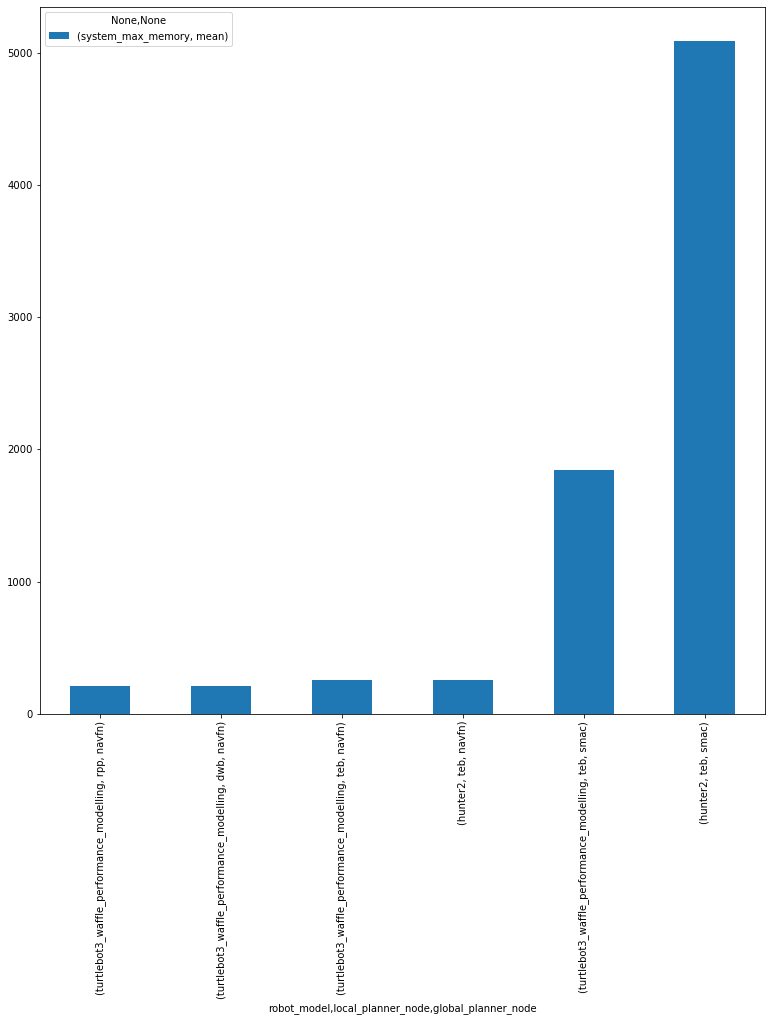

In [179]:
cpu_time_metrics_df = df.groupby([df.robot_model, df.local_planner_node, df.global_planner_node])[max_memory_metrics].agg(['min', 'mean', 'max']).sort_values(by=('system_max_memory', 'mean'))/1024**2
cpu_time_metrics_df.plot.bar(y=('system_max_memory', 'mean'))
cpu_time_metrics_df